<a href="https://colab.research.google.com/github/fsmox/GameAI/blob/main/src/WJDRAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os
import re

In [ ]:
import os
import sys

# 检查是否在 Google Colab 环境中
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# 根据运行环境设置数据文件夹路径
if is_colab():
    DataFolder = 'drive/MyDrive/AIData'
    sys.path.append('/content/drive/MyDrive/Colab Notebooks')
    from Model import CaptureDataset, ResizePad,ClickPredictionModel
    print("Running on Google Colab. Data folder set to:", DataFolder)
else:
    sys.path.append(os.getcwd())
    from Model import CaptureDataset, ResizePad,ClickPredictionModel
    DataFolder = os.path.join(os.getcwd())
    model_path = os.path.join(os.getcwd(), 'Model','click_prediction_model.pth')
    print("Running locally. Data folder set to:", DataFolder)

In [ ]:
class ResizePad:
    def __init__(self, target_size, fill=0):
        """
        :param target_size: (width, height) 目标尺寸，例如 (224, 224)
        :param fill: 填充颜色（单通道值或 RGB 元组），默认为 0（黑色）
        """
        self.target_w, self.target_h = target_size
        self.fill = fill

    def __call__(self, image):
        # 原始尺寸
        orig_w, orig_h = image.size
        # 计算缩放因子：保持长宽比例，使得缩放后的图像尺寸不超过目标尺寸
        scale = min(self.target_w / orig_w, self.target_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)

        # 缩放图片
        image = F.resize(image, (new_h, new_w))

        # 计算左右和上下填充量
        pad_w = self.target_w - new_w
        pad_h = self.target_h - new_h

        # 左右、上下均分填充（如果不均分，可根据需求调整）
        left = pad_w // 2
        top = pad_h // 2
        right = pad_w - left
        bottom = pad_h - top

        # 填充图片
        image = F.pad(image, (left, top, right, bottom), fill=self.fill)
        return image

# 自定义 Dataset，适用于文件名格式为：
# {now}_{screenshot_counter}_{x1}_{y1}_{x2}_{y2}_{Pressed_x}_{Pressed_y}_{x}_{y}_{extra}.png
class CaptureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 筛选出所有png文件
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        # 正则表达式匹配11个字段，日期和时间字段允许包含'-'，其他字段均为数字
        self.filename_pattern = re.compile(
            r"(\d+-\d+-\d+_\d+-\d+-\d+)_(\d+)_x1_(\d+)_y1_(\d+)_x2_(\d+)_y2_(\d+)_Px_(\d+)_Py_(\d+)_Rx_(\d+)_Ry_(\d+)\.png"
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        match = self.filename_pattern.match(img_name)
        if not match:
            raise ValueError(f"文件名格式错误: {img_name}")
        groups = match.groups()
        # 根据文件名说明：
        # groups[0]: now (日期，如 "2025-03-15")
        # groups[1]: screenshot_counter (时间，如 "18-13-54")
        # groups[2]: x1, groups[3]: y1, groups[4]: x2, groups[5]: y2
        # groups[6]: Pressed_x, groups[7]: Pressed_y, groups[8]: x, groups[9]: y
        # groups[10]: 额外字段（忽略）
        try:
            x1 = int(groups[2])
            y1 = int(groups[3])
            x2 = int(groups[4])
            y2 = int(groups[5])
            Pressed_x = int(groups[6]) - x1
            Pressed_y = int(groups[7]) - y1
            Px = Pressed_x / (x2 - x1)
            Py = Pressed_y / (y2 - y1)
            # groups[8] 和 groups[9] 可能是其他坐标，暂时忽略
            x = int(groups[8])
            y = int(groups[9])
            # print(f"文件名: {img_name}")
            # print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}, Pressed_x: {Pressed_x}, Pressed_y: {Pressed_y}")
            # print(f"{img_name}, Px: {Px}, Py: {Py}")
        except Exception as e:
            raise ValueError(f"解析数字失败，文件名: {img_name}") from e

        # 加载图像并转换
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 输入参数为 (x1, y1, x2, y2)，目标参数为 (Pressed_x, Pressed_y, x, y)
        input_tensor = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
        # target_tensor = torch.tensor([Pressed_x, Pressed_y, x, y], dtype=torch.float32)
        target_tensor = torch.tensor([Px, Py], dtype=torch.float32)

        return image, input_tensor, target_tensor

def GetUsedDevice():
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    if use_cuda:
        device = torch.device("cuda")
        print("Using CUDA")
    elif use_mps:
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


def DataLoderTest():
    # 获取当前脚本所在目录，并拼接 Capture 文件夹路径
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    # current_dir = os.getcwd()
    # capture_folder = os.path.join(current_dir, DataFolder)
    capture_folder = os.path.join(DataFolder, "Data")
    print("Capture folder:", capture_folder)

    # 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
    transform = transforms.Compose([
        ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # 初始化 Dataset 和 DataLoader
    dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

    device = GetUsedDevice()

    # Load the pre-trained ClickPredictionModel
    model = None
    if os.path.exists(model_path):
        model = ClickPredictionModel()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    else:
        print("Model not found. Please run the 'TrainModel' notebook first.")

    count = 0
    # 测试 DataLoader 是否正确加载数据
    for images, inputs, targets in dataloader:
        if model:
            # Pass x1, y1 to the model
            with torch.no_grad():
                prediction = model(images, inputs)  # Pass x1, y1 to the model
        for i in range(5):
            x1, y1, x2, y2 = inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3]
            P_x, P_y = targets[i][0], targets[i][1]
            print(P_x, P_y)
            now_width = 224/(y2 - y1) * (x2 - x1)
            target_x = now_width * P_x + (224 - now_width)/2
            target_y = 224 * P_y
            print(f"Image: {images[i].shape}, Input: {inputs[i]}, Target: {targets[i]}")
            print(f"Target coordinates: ({target_x.item()}, {target_y.item()})")
            # 反归一化图像数据
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            img = images[i] * std[:, None, None] + mean[:, None, None]
            img = img.permute(1, 2, 0).numpy()  # 调整维度顺序以适应 matplotlib
            img = (img * 255).astype('uint8')  # 转换为 uint8 类型
            plt.scatter(target_x.item(), target_y.item(), color='red', s=80)
            if model:
                predicted_x, predicted_y = prediction[i][0], prediction[i][1]
                predicted_x = now_width * predicted_x + (224 - now_width)/2
                predicted_y = 224 * predicted_y
                plt.scatter(predicted_x.item(), predicted_y.item(), color='blue', s=80)
            plt.imshow(img)
            plt.show()
        break


In [ ]:
def main():
    # 检查设备
    device = GetUsedDevice()

    # 获取当前脚本所在目录，并拼接 Capture 文件夹路径
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    capture_folder = os.path.join(current_dir, DataFolder, "Data")

    # 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
    transform = transforms.Compose([
        ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # 初始化 Dataset 和 DataLoader
    dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    # 创建模型
    model = ClickPredictionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 读取模型
    if os.path.exists("click_prediction_model.pth"):
        model.load_state_dict(torch.load("click_prediction_model.pth", map_location=device))

    # 训练模型
    epochs = 5
    loss_fn = nn.SmoothL1Loss()
    for epoch in range(epochs):
        for img, input_xy, target_xy in dataloader:
            img, input_xy, target_xy = img.to(device), input_xy.to(device), target_xy.to(device)
            optimizer.zero_grad()
            output_xy = model(img, input_xy)
            loss = loss_fn(output_xy, target_xy)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        # 保存模型
        torch.save(model.state_dict(), "click_prediction_model.pth")


Capture folder: /workspace/examples/0_Src/Data
Using CUDA
tensor(0.8428) tensor(0.5424)
Image: torch.Size([3, 224, 224]), Input: tensor([1538.,   19., 1856.,  620.]), Target: tensor([0.8428, 0.5424])
Target coordinates: (152.62562561035156, 121.50415802001953)


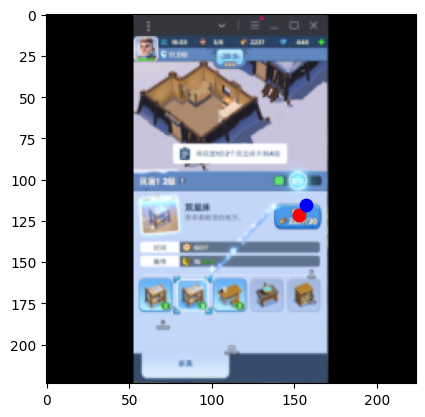

tensor(0.8671) tensor(0.3557)
Image: torch.Size([3, 224, 224]), Input: tensor([1538.,   22., 1854.,  618.]), Target: tensor([0.8671, 0.3557])
Target coordinates: (155.59732055664062, 79.67784881591797)


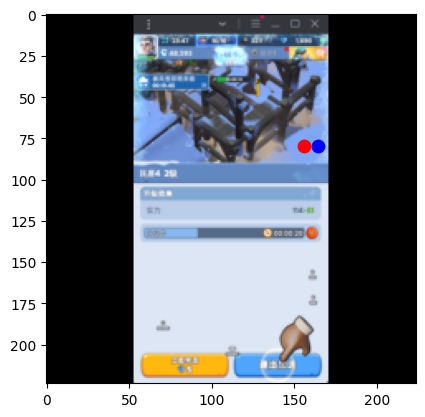

tensor(0.3038) tensor(0.3473)
Image: torch.Size([3, 224, 224]), Input: tensor([1538.,   22., 1854.,  618.]), Target: tensor([0.3038, 0.3473])
Target coordinates: (88.69798278808594, 77.79866027832031)


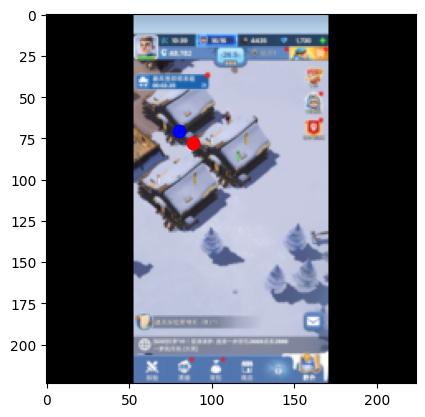

tensor(0.8797) tensor(0.5805)
Image: torch.Size([3, 224, 224]), Input: tensor([1538.,   22., 1854.,  618.]), Target: tensor([0.8797, 0.5805])
Target coordinates: (157.10067749023438, 130.04026794433594)


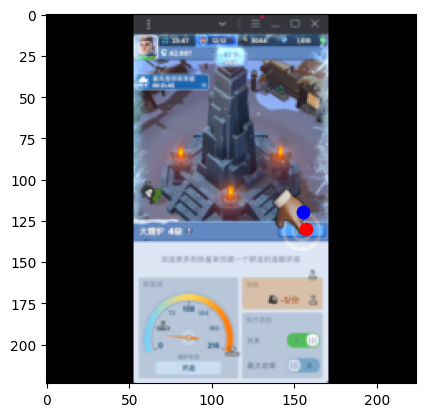

tensor(0.8239) tensor(0.4493)
Image: torch.Size([3, 224, 224]), Input: tensor([1538.,   19., 1856.,  620.]), Target: tensor([0.8239, 0.4493])
Target coordinates: (150.38934326171875, 100.63227844238281)


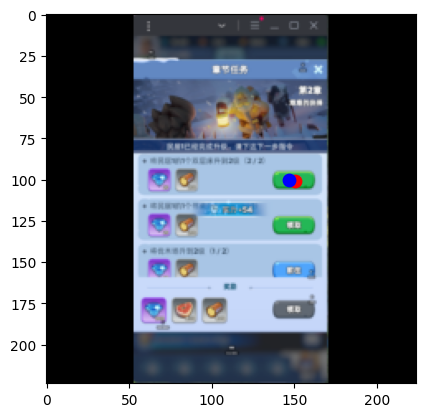

In [8]:
DataLoderTest()

In [ ]:
class SumSquaredErrorLoss(nn.Module):
    def __init__(self):
        super(SumSquaredErrorLoss, self).__init__()

    def forward(self, pred, target):
        # (x1 - y1)^2 + (x2 - y2)^2
        return torch.sum((pred - target) ** 2, dim=-1).mean()

In [ ]:
# 检查设备
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
if use_cuda:
  device = torch.device("cuda")
  print("Using CUDA")
elif use_mps:
  device = torch.device("mps")
  print("Using MPS")
else:
  device = torch.device("cpu")
  print("Using CPU")

# 获取当前脚本所在目录，并拼接 Capture 文件夹路径
# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
capture_folder = os.path.join(current_dir, DataFolder, "Data")

# 定义图像预处理（调整尺寸和归一化，符合 ResNet50 要求）
transform = transforms.Compose([
    ResizePad((224, 224), fill=(0, 0, 0)),  # 使用黑色填充
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 初始化 Dataset 和 DataLoader
dataset = CaptureDataset(root_dir=capture_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# 创建模型
model = ClickPredictionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)



# 读取模型
if os.path.exists(model_path):
  model.load_state_dict(torch.load(model_path, map_location=device))

# 训练模型
epochs = 50
loss_fn = SumSquaredErrorLoss()

for epoch in range(epochs):
  for img, input_xy, target_xy in dataloader:
    img, input_xy, target_xy = img.to(device), input_xy.to(device), target_xy.to(device)
    optimizer.zero_grad()
    output_xy = model(img, input_xy)
    loss = loss_fn(output_xy, target_xy)
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")
  # 保存模型
  torch.save(model.state_dict(), model_path)

In [ ]:
use_cuda = torch.cuda.is_available()
use_cuda

# 新段落

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install py7zr
import os
import py7zr

# 获取当前目录
current_directory = os.getcwd()

# 查找当前目录下的 Data.7z 文件
data_file = os.path.join(current_directory, 'Data.7z')

if os.path.exists(data_file):
    # 解压到 DataFolder 文件夹
    with py7zr.SevenZipFile(data_file, mode='r') as z:
        z.extractall(path=DataFolder)
        print(f"文件 {data_file} 解压到 {DataFolder} 文件夹.")
else:
    print(f"文件 {data_file} 不存在.")